# Dans cette section, nous allons nous intéresser à la classification des textes par catégorie: 

# Nous verrons comment: 

## 1) charger le contenu du fichier et les catégories
## 2) explorer la base de données
## 3) pré-traitement de la base de données
## 4) Partition en corpus d’apprentissage et de test
## 5) extraire des vecteurs caractéristiques adaptés à l'apprentissage automatique (Construction de la matrice documents termes pour l’apprentissage)
## 6) former un modèle  pour effectuer la catégorisation
## 7) utiliser une stratégie de recherche de grille pour trouver une bonne configuration des composants d'extraction de caractéristiques et du classificateur
## 8) Remarques et une touche de NLTK (pour le stemming)
## 9) Déploiement de mon modèle
## 10) Conclusion


############################

##  **La Classification des documents / Texte**

> ### est l' une des tâches importantes et typique du machine learning supervisé. C'est affecter des catégories à des documents, qui peuvent être une page Web, un livre de bibliothèque, des articles de presse, etc. contient de nombreuses applications telles que le filtrage de spam, le routage de courriers électroniques, l'analyse des sentiments, etc. 

# 1) charger le contenu du fichier et les catégories

## *À propos de cet ensemble de données* 

### Cet ensemble de données contient les titres, les URL et les catégories de 422 937 reportages collectés par un agrégateur Web entre le 10 mars 2014 et le 10 août 2014.

### Les catégories de nouvelles incluses dans cet ensemble de données incluent les entreprises; science et technologie; divertissement; et la santé. Différents articles de presse faisant référence au même article (par exemple, plusieurs articles sur les statistiques de l’emploi récemment publiées) sont également classés ensemble.

## *Contenu * 
### Les colonnes incluses dans cet ensemble de données sont les suivantes:

> ID : l'ID numérique de l'article

> TITRE : le titre de l'article

> URL : l'URL de l'article

> EDITEUR : l'éditeur de l'article

> CATÉGORIE : la catégorie de l'information; un de: - b : business - t : science et technologie - e : divertissement - m : santé

> HISTOIRE : identifiant alphanumérique du reportage que l'article traite

> HOSTNAME : nom d'hôte où l'article a été publié

> TIMESTAMP : horodatage approximatif de la publication de l'article, donné en heure Unix (secondes écoulées depuis minuit le 1er janvier 1970)

## *Source*
> Cet ensemble de données provient du référentiel UCI Machine Learning [https://archive.ics.uci.edu/ml/datasets/News+Aggregator]. Irvine, Californie: Université de Californie, École d’information et d’informatique.

In [1]:
import pandas as pd
news = pd.read_csv("C:/Users/User/Desktop/uci-news-aggregator.csv") #Importing data from CSV
news = news.sample(frac=1, random_state=42) #Renvoie un échantillon aléatoire d'éléments

In [2]:
news.columns #colonnes de la base

Index(['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME',
       'TIMESTAMP'],
      dtype='object')

In [3]:
#enlever les colonnes qui nous intéressent pas dans notre étude
columns=['TITLE','PUBLISHER','CATEGORY']
news=news[columns]
news=news.dropna(axis=0)
news=news.reset_index()
news=news.drop(['index'],axis=1)

In [4]:
#visulaliser les 5 premiers lignes due la base 
news.head(5)

,TITLE,PUBLISHER,CATEGORY
0,Only 2 people allowed in the delivery room: Pr...,India Today,e
1,"A wealth of info, a welter of questions",KSPR,b
2,Robin Thicke Naming Album After Paula Patton…,Hollywood Life,e
3,Actress And Civil Rights Activist Ruby Dee Die...,We Got This Covered,e
4,Feds to review Ga. Medicaid backlog,McDuffie Mirror,m


# 2) explorer la base de données

In [5]:
news.columns

Index(['TITLE', 'PUBLISHER', 'CATEGORY'], dtype='object')

In [6]:
#dimension de la base
news.shape

(422417, 3)

In [7]:
# summary statistics de la base (count, unique, top, freq)
news.describe()

,TITLE,PUBLISHER,CATEGORY
count,422417,422417,422417
unique,406453,10985,4
top,The article requested cannot be found! Please ...,Reuters,e
freq,145,3902,152469


In [8]:
#bref résumé sur la base
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422417 entries, 0 to 422416
Data columns (total 3 columns):
TITLE        422417 non-null object
PUBLISHER    422417 non-null object
CATEGORY     422417 non-null object
dtypes: object(3)
memory usage: 9.7+ MB


## Count Vs Publication

C:\Users\User\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Counts Vs PUBLISHER')

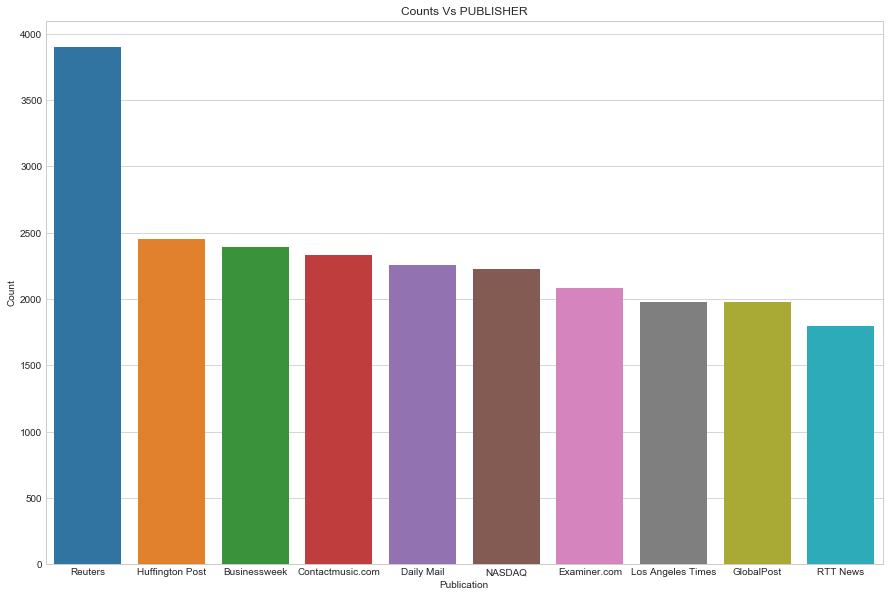

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
z=news.groupby(by=['PUBLISHER'],as_index=False).count().sort_values(by='TITLE',ascending=False).head(10)

plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(x=z['PUBLISHER'],y=z['TITLE'], data=z)
plt.xlabel("Publication")
plt.ylabel("Count") 
plt.title("Counts Vs PUBLISHER")

> Le graphique à barres ci-dessus montre les 10 premiers publieurs dans l'ensemble de données d'actualité en vue du nombre de publications.  Reuters a le numéro le plus élevé des publications.

## Count Vs Category

C:\Users\User\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Counts Vs Category')

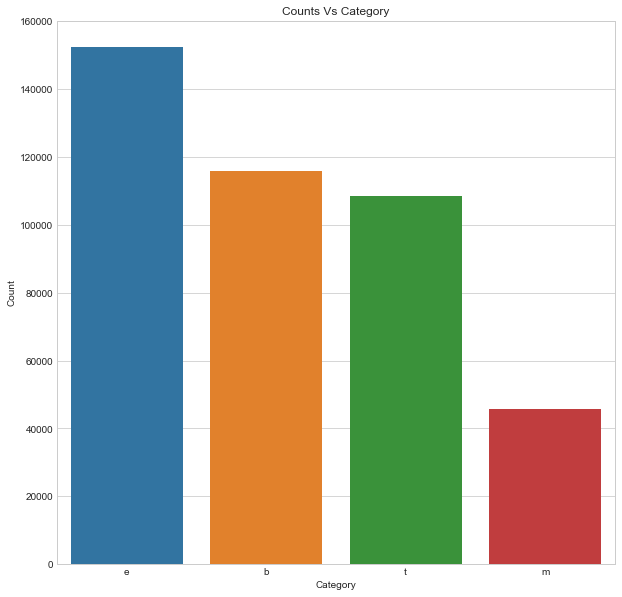

In [10]:
z=news.groupby(by=['CATEGORY'],as_index=False).count().sort_values(by='TITLE',ascending=False).head(10)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x=z['CATEGORY'],y=z['TITLE'], data=z)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Counts Vs Category")

### Le graphique à barres ci-dessus montre la distribution des publications par catégorie sachant que 
>  **e** :  Entertainment

>  **b** : business 

>  **t** : Science and technology

>  **m** : health

## Dorénavant, nous allons nous intéresser seulement aux colonnes "TITLE" et "CATEGORY"

In [11]:
columns=['TITLE','CATEGORY']
news=news[columns]
news=news.dropna(axis=0)
news=news.reset_index()
news=news.drop(['index'],axis=1)

In [12]:
news.head(5)

,TITLE,CATEGORY
0,Only 2 people allowed in the delivery room: Pr...,e
1,"A wealth of info, a welter of questions",b
2,Robin Thicke Naming Album After Paula Patton…,e
3,Actress And Civil Rights Activist Ruby Dee Die...,e
4,Feds to review Ga. Medicaid backlog,m


# 3) Pré-traitement de la base de données

In [13]:
# supprimer les colonnes TITRE en double (d'après le summary , on n'a pas trouvé des titres vides 
#mais, en revanche, on a trouvé des titres en double )
news = news.drop_duplicates('TITLE')
news.shape

(406453, 2)

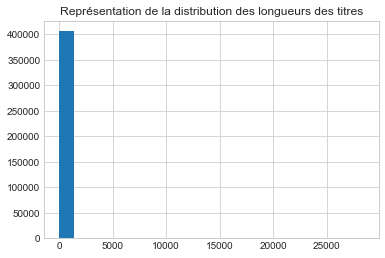

In [14]:
# Vérifier la distibution des longueurs des titres
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
tst=news.TITLE.map(len)
plt.hist(tst, bins=20)  # arguments are passed to np.histogram
plt.title("Représentation de la distribution des longueurs des titres")
plt.show()

> ## On n'a pas besoin de limiter les longueurs des titres puisque la distribution est uniforme

# Maintenant, nous allons créer une fonction qui: 
### enlève les caractères non ascii
### miniscule les titres et les tokenise
### fait appel au stopwords de nltk et les enlève

In [15]:
from nltk.corpus import stopwords
def get_words( headlines ):               
    headlines_onlyletters = re.sub("[^a-zA-Z]", " ",headlines) #Remove everything other than letters     
    words = headlines_onlyletters.lower().split() #Convert to lower case, split into individual words    
    stops = set(stopwords.words("english"))  #Convert the stopwords to a set for improvised performance                 
    meaningful_words = [w for w in words if not w in stops]   #Removing stopwords
    return( " ".join( meaningful_words )) #Joining the words

In [16]:
from tqdm import tqdm, tqdm_notebook

pd.options.display.max_columns = 200
pd.options.mode.chained_assignment = None

from collections import Counter
import re
import numpy as np

tqdm_notebook().pandas()
from tqdm._tqdm_notebook import tqdm_notebook

tqdm_notebook.pandas()

A Jupyter Widget

## Une nouvelle colonne «cleaned_text» peut être facilement créée à l'aide de la méthode "progress_map" appliquée à la colonne «TITLE».

In [17]:
cleaned_text = news.TITLE.progress_map(get_words)

A Jupyter Widget

In [18]:
#concaténer la base news et la nouvelle colonne cleaned_text 
news =pd.concat([news, cleaned_text], axis=1, sort=False)

In [19]:
news.head(5)

,TITLE,CATEGORY,TITLE
0,Only 2 people allowed in the delivery room: Pr...,e,people allowed delivery room pregger mila kuni...
1,"A wealth of info, a welter of questions",b,wealth info welter questions
2,Robin Thicke Naming Album After Paula Patton…,e,robin thicke naming album paula patton
3,Actress And Civil Rights Activist Ruby Dee Die...,e,actress civil rights activist ruby dee dies
4,Feds to review Ga. Medicaid backlog,m,feds review ga medicaid backlog


In [20]:
myList = list(news.columns)
myList[2] = 'cleaned_text'
news.columns = myList

In [21]:
news.head(5)

,TITLE,CATEGORY,cleaned_text
0,Only 2 people allowed in the delivery room: Pr...,e,people allowed delivery room pregger mila kuni...
1,"A wealth of info, a welter of questions",b,wealth info welter questions
2,Robin Thicke Naming Album After Paula Patton…,e,robin thicke naming album paula patton
3,Actress And Civil Rights Activist Ruby Dee Die...,e,actress civil rights activist ruby dee dies
4,Feds to review Ga. Medicaid backlog,m,feds review ga medicaid backlog


### Nous avons besoin maintenant d'encoder la variable CATEGORY en tant que variable catégorielle 

In [22]:
news['category_id'] = news['CATEGORY'].factorize()[0] 

In [23]:
news.head(5)

,TITLE,CATEGORY,cleaned_text,category_id
0,Only 2 people allowed in the delivery room: Pr...,e,people allowed delivery room pregger mila kuni...,0
1,"A wealth of info, a welter of questions",b,wealth info welter questions,1
2,Robin Thicke Naming Album After Paula Patton…,e,robin thicke naming album paula patton,0
3,Actress And Civil Rights Activist Ruby Dee Die...,e,actress civil rights activist ruby dee dies,0
4,Feds to review Ga. Medicaid backlog,m,feds review ga medicaid backlog,2


In [24]:
news.CATEGORY.value_counts()

e    146856
b    111534
t    104418
m     43645
Name: CATEGORY, dtype: int64

In [25]:
news.category_id.value_counts()

0    146856
1    111534
3    104418
2     43645
Name: category_id, dtype: int64

In [26]:
# 0: e:  Entertainment
# 1: b: business 
# 2: m: health
# 3: t: Science and technology

## Une fois les données sont propres, nous les enregistrons sur le disque

In [27]:
news[['cleaned_text', 'category_id']].to_csv('./data/final_text2.csv')

In [1]:
import pandas as pd
data = pd.read_csv('./data/final_text2.csv')
print(data.shape)

(406453, 3)


In [2]:
print(data.head(5))

   Unnamed: 0                                       cleaned_text  category_id
0           0  people allowed delivery room pregger mila kuni...            0
1           1                       wealth info welter questions            1
2           2             robin thicke naming album paula patton            0
3           3        actress civil rights activist ruby dee dies            0
4           4                    feds review ga medicaid backlog            2


In [3]:
data= data.drop('Unnamed: 0',axis=1)

In [4]:
data.head(5)

,cleaned_text,category_id
0,people allowed delivery room pregger mila kuni...,0
1,wealth info welter questions,1
2,robin thicke naming album paula patton,0
3,actress civil rights activist ruby dee dies,0
4,feds review ga medicaid backlog,2


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406453 entries, 0 to 406452
Data columns (total 2 columns):
cleaned_text    406443 non-null object
category_id     406453 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.2+ MB


# 4) Partition en corpus d’apprentissage et de test

## => Avant, parlons un peu sur le Processus de catégorisation de textes

### Il importe de ne pas utiliser les mêmes donnés pour la modélisation et l’évaluation des classifieurs dans une démarche d’analyse prédictive. 

###  une partie des observations est extraite aléatoirement, on parle d’échantillon d’apprentissage, elle est dévolue à la construction du modèle ; la partie restante, dite échantillon test, est consacrée à la mesure des performances. La répartition 2/3 vs. 1/3 est souvent utilisée mais il n’y a pas de règle véritable en la matière.

### Dans le cadre de la catégorisation de textes, cela se traduit par une partition du corpus AVANT la construction des matrices documents termes. Il ne faut pas que les observations du corpus de test puissent intervenir dans la constitution du dictionnaire (la liste des termes) et dans le calcul des pondérations (si on utilise la pondération TF-IDF par exemple) de la matrice utilisée pour l’apprentissage.

### Cette contrainte – partition des corpus avant la construction des matrices documents termes – prend tout son sens lorsque nous utilisons le classifieur final en déploiement, lors du classement d’un document supplémentaire qui n’est pas disponible lors de la phase de modélisation. Il est évident qu’il ne doit intervenir en rien dans la construction du modèle :

### s’il introduit des termes inconnus dans la phase de modélisation, ils doivent être ignorés ; demême, nous ne connaissons pas le nombre de documents à classer lors du cycle de vie du modèle, le calcul de l’IDF des termes (inverse document frequency) doit se baser exclusivement sur les informations issues de l’échantillon d’apprentissage.


> ### Nous créons les corpus d’apprentissage et de test avec, respectivement, ntrain = 2/3=270969 documents etntest = 1/3= 135484 documents, via une partition au hasard, stratifiée selon les classes pour préserver les proportions des 4 catégories dans les sous-ensembles.
> ### Nous utilisons la procédure train_test_split du module sklearn.model_selection.

In [6]:
#subdivision into train and test sets
X, y = data.cleaned_text.fillna(' '), data.category_id
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=1/3, train_size=2/3, 
                                                    random_state=42,
                                                    stratify=y)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(270968,) (135485,) (270968,) (135485,)


In [7]:
#frequency distribution of the class attribute
#train set
freqTrain = pd.crosstab(index=y_train,columns="count")
print(freqTrain/freqTrain.sum())
#test set
freqTest = pd.crosstab(index=y_train,columns="count")
print(freqTest/freqTest.sum())

col_0           count
category_id          
0            0.361312
1            0.274409
2            0.107378
3            0.256901
col_0           count
category_id          
0            0.361312
1            0.274409
2            0.107378
3            0.256901


> Les proportions sont bien respectées, la précision de l’évaluation n’en sera qu’améliorée.

# 5) Extraire des fonctionnalités 
### Les fichiers texte sont en réalité des séries de mots (ordonnés). Afin d'exécuter des algorithmes d'apprentissage automatique, nous devons convertir les fichiers texte en vecteurs d'entités numériques.
### En fait, Les classificateurs ont derrière eux des opérations mathématiques qui ne fonctionnent que sur des nombres. Nous devrons donc transformer notre contribution sous forme numérique. 

# a) Bag of words:
### La manière la plus intuitive de le faire est la représentation par sacs de mots:
### En bref, nous segmentons chaque fichier texte en mots (pour la division en anglais par espace) et comptons le nombre de fois où chaque mot apparaît dans chaque document et assignons enfin un identifiant à chaque mot. Chaque mot unique dans notre dictionnaire correspondra à une fonctionnalité (fonction descriptive).

### Scikit-learn possède un composant de haut niveau qui créera des vecteurs de fonctionnalités pour nous "CountVectorizer".

### (1) Nous instancions l’objet de calcul CountVectorizer. 
### (2) Nous appelons la méthode fit_transform() en passant en paramètre les messages du corpus d’apprentissage x_train.

In [8]:
#import the CountVectorizer tool
from sklearn.feature_extraction.text import CountVectorizer
parseur = CountVectorizer(min_df=10)
# ngram_range=(1, 2)
#create the document term matrix
XTrain = parseur.fit_transform(x_train)

> min_df : float dans la plage [0.0, 1.0] ou int, valeur par défaut = 1

Lors de la construction du vocabulaire, ignorez les termes ayant une fréquence de document strictement inférieure au seuil donné. Cette valeur est également appelée coupure dans la littérature. 

### Ici, en faisant ' parseur.fit_transform (x_train) ', nous apprenons le dictionnaire de vocabulaire et il retourne une matrice de document-terme [n_samples, n_features].

### Ainsi, Nous pouvons afficher le nombre et la liste des termes qui composent le dictionnaire.

In [36]:
#number of tokens
print(len(parseur.get_feature_names()))
#list of tokens
print(parseur.get_feature_names())

13649
['aa', 'aaa', 'aaliyah', 'aapl', 'aaron', 'abandon', 'abandoned', 'abandoning', 'abandons', 'abba', 'abbott', 'abbv', 'abbvie', 'abby', 'abc', 'abe', 'abercrombie', 'abilities', 'ability', 'able', 'abnormalities', 'aboard', 'aborted', 'abortion', 'abound', 'abrams', 'abramson', 'abroad', 'abruptly', 'abs', 'absence', 'absolute', 'absolutely', 'absurd', 'abu', 'abundant', 'abuse', 'abused', 'abusing', 'ac', 'aca', 'academic', 'academy', 'accelerate', 'accelerated', 'accelerates', 'accelerating', 'acceleration', 'accelerators', 'accent', 'accept', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accessed', 'accessible', 'accessories', 'accessory', 'accident', 'accidental', 'accidentally', 'accidents', 'acclaimed', 'accord', 'according', 'account', 'accounting', 'accounts', 'accra', 'accuracy', 'accurate', 'accurately', 'accusations', 'accuse', 'accused', 'accuser', 'accuses', 'ace', 'achieve', 'achievement', 'achievements', 'achieves', 'acid', 'acidification', 'acids', 

> Nous observons 13649 termes.

# b) Des occurrences aux fréquences 
### Le nombre d'occurrences est un bon début, mais il y a un problème: les documents plus longs auront des valeurs moyennes plus élevées que les documents plus courts, même s'ils peuvent parler des mêmes sujets.

### Pour éviter ces divergences potentielles, il suffit de diviser le nombre d'occurrences de chaque mot d'un document par le nombre total de mots du document: ces nouvelles fonctionnalités sont appelées tf (fréquences de terme).

### Un autre raffinement de tf consiste à réduire les poids pour les mots qui apparaissent dans de nombreux documents du corpus et sont donc moins informatifs que ceux qui ne se produisent que dans une petite partie du corpus.

### Cette réduction est appelée tf-idf (la fréquence d'un terme (TF) multipliée par la fréquence de document inverse (IDF) ).

### En d'autres termes, plus le score TF * IDF (poids) est élevé, plus le terme est rare et inversement.

### Les deux tf et tf-idf peut être calculée comme suit:

In [9]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
tf_transformer = tfidf_transformer.fit(XTrain) #méthode pour adapter notre estimateur aux données
X_train_tf = tf_transformer.transform(XTrain) #méthode pour transformer notre matrice de comptage en une représentation tf-idf
X_train_tf.shape

(270968, 13649)

### Pour la base d'apprentissage, nous avons obtenu une matrice tf-idf de dimension (270968, 13649)

# 6) Former un classificateur 

### Maintenant que nous avons nos fonctionnalités, nous pouvons former un classificateur pour essayer de prédire la catégorie d'un article. 
### Différents algorithmes peuvent être utilisés pour la classification de texte. Commençons par un classificateur Naives Bayes , qui fournit une base de référence intéressante pour cette tâche.

# 1) Multinomial Naive Bayes 

## *Parlons un peu sur l'algorithme Naive Bayes * 

### **C'est une technique de classification basée sur le  théorème de Bayes avec une hypothèse d'indépendance parmi les prédicteurs. En termes simples, un classificateur Naive Bayes suppose que la présence d'une entité particulière dans une classe n'est pas liée à la présence d'une autre entité. Par exemple, un fruit peut être considéré comme une pomme s'il est rouge, rond et d'environ 3 pouces de diamètre. Même si ces caractéristiques dépendent les unes des autres ou sur l'existence des autres caractéristiques, toutes ces propriétés contribuent indépendamment à la probabilité que ce fruit soit une pomme et c'est pourquoi on l'appelle «Naive».**

### Le modèle Naive Bayes est facile à construire et particulièrement utile pour les très grands ensembles de données. En plus de la simplicité, Naive Bayes est connue pour surpasser les méthodes de classification les plus sophistiquées.


### scikit-learn comprend plusieurs variantes de ce classificateur; le plus approprié pour le compte de mots est la variante multinomiale:

### Vous pouvez facilement construire un NBclassifier dans scikit en utilisant 2 lignes de code ci-dessous:

In [10]:
#import the class LogistiRegression
from sklearn.naive_bayes import MultinomialNB
#instatiate the object
modelFirst = MultinomialNB()

In [11]:
#perform the training process
clf= modelFirst.fit(X_train_tf,y_train)

In [12]:
clf

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

> **Paramètres de MultinomialNB**

#### *alpha* : paramètre de lissage additif (1: par défaut, 0 pour aucun lissage)

#### *fit_prior* : permet d'apprendre les classes antérieures (true: par défaut, false: signifie q'un uniforme antérieur sera utilisé) 

#### *class_prior* : taille(n_classes) : probabilités antérieures de classes (aucun: par défaut, si spécifié: les valeurs antérieures ne sont pas ajustées en fonction des données) 

## Evaluation sur l’échantillon test

### Pour appliquer le modèle sur le corpus de texte, nous devons construire la matrice documents termes correspondante, en utilisant le dictionnaire issu de l’apprentissage.
### Nous appliquons la méthode transform() de l’objet parseur instancié lors de la phase d’apprentissage sur le corpus de test issu de la partition aléatoire des données .

In [13]:
X_test=parseur.transform(x_test)
X_test_tf= tf_transformer.transform(X_test)
X_test_tf.shape

(135485, 13649)

> Nous avons une matrice (135485, 13649) cette fois-ci :
135485 lignes parce qu’il y a 135485 documents dans le corpus de test, 
13649 colonnes parce que 13649 termes ont été extraits du corpus d’apprentissage.

> Nous calculons les prédictions du modèle sur les documents de l’échantillon test…

In [14]:
#prediction for the test set
predTest = clf.predict(X_test_tf)

## Performance du classificateur NB: 
### Nous allons maintenant tester les performances du classificateur NB sur l’ ensemble de test et déduisons les différents indicateurs de performances en les confrontant avec lesvaleurs observées de l’attribut cible sur l’échantillon test.
### Nous utilisons les procédures dumodule metrics de scikit-learn.

In [15]:
#import the metrics class for the performance measurement
from sklearn import metrics
#confusion matrix
mcTest = metrics.confusion_matrix(y_test,predTest)
print(mcTest)

#accuracy rate
print(metrics.accuracy_score(y_test,predTest))

print(metrics.classification_report(y_test, predTest))       

[[47389   639   157   767]
 [  786 33703   311  2378]
 [  714   733 12716   386]
 [  826  2388   201 31391]]
0.924080156475
             precision    recall  f1-score   support

          0       0.95      0.97      0.96     48952
          1       0.90      0.91      0.90     37178
          2       0.95      0.87      0.91     14549
          3       0.90      0.90      0.90     34806

avg / total       0.92      0.92      0.92    135485



####################################################################################################"

### Voilà! Voici un résumé de ce que j'ai fait: j'ai chargé les données, les ai divisées en formations et tests, ajusté un modèle aux données d'entraînement, fait des prédictions basées sur ces données et testé les prédictions sur les données de test. Semble bon, non? Mais la séparation train / test présente des dangers - et si la scission que nous faisons n'est pas aléatoire ? Que se passe-t-il si un sous-ensemble de nos données ne comprend que des article d'une certaie catégorie mais pas d'autres catégories. Cela se traduira par un ajustement excessif, même si nous essayons de l'éviter! C'est là qu'intervient la validation croisée.

### Le schéma apprentissage-test n’est pas adapté lorsque nous traitons des bases de taille réduite. Donc, il est plus judicieux dans ce cas d’utiliser la totalité de la base pour élaborer le modèle prédictif, puis de passer par une technique de rééchantillonnage pour en évaluer les performances, typiquement la validation croisée ou le bootstrap.

### La validation croisée est très similaire à la séparation train / test, mais il s’applique à plus de sous-ensembles. Cela signifie que nous divisons nos données en k sous-ensembles et que nous nous entraînons sur l'un de ces sous-ensembles. Ce que nous faisons est de tenir le dernier sous-ensemble pour le test. Nous sommes en mesure de le faire pour chacun des sous-ensembles.

### Il y a un tas de méthodes de validation croisée ; Pour les problèmes de classification, on utilise généralement la validation croisée par k-fois stratifiée, dans laquelle les plis sont sélectionnés de sorte que chaque pli contient à peu près les mêmes proportions d'étiquettes de classe. 

###  *Validation croisée K-Folds en plus de détails *
> l'échantillon original est partitionné au hasard en k sous-échantillons de taille égale. Parmi les k sous-échantillons, un seul sous-échantillon est retenu comme données de validation pour tester le modèle et les sous-échantillons k-1 restants sont utilisés comme données d'apprentissage. Le processus de validation croisée est ensuite répété k fois (les plis), chacun des k sous-échantillons étant utilisé exactement une fois comme données de validation. Les k résultats des plis peuvent ensuite être moyennés (ou combinés autrement) pour produire une estimation unique. L'avantage de cette méthode est que toutes les observations sont utilisées à la fois pour l'entraînement et la validation, et chaque observation est utilisée pour la validation une seule fois.

### J'ai pensé que l'utilisation de l'itérateur de validation croisée comme une boucle externe est une bonne idée et un point de départ qui rendrait mes étapes claires et lisibles:

In [44]:
from sklearn.cross_validation import KFold
kf = KFold(y.shape[0], n_folds=10) # j'ai choisi 10 comme nombre de folds
for train_index, test_index in kf:
    x_train_cv, y_train_cv = X[train_index], y[train_index] 
    x_test_cv, y_test_cv = X[test_index], y[test_index]
    #Now continue with your pre-processing steps..

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [45]:
#import the CountVectorizer tool
from sklearn.feature_extraction.text import CountVectorizer
parseur = CountVectorizer(min_df=10)
# ngram_range=(1, 2)
#create the document term matrix
XTrain_cv = parseur.fit_transform(x_train_cv)

In [46]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
tf_transformer_cv = tfidf_transformer.fit(XTrain_cv) #méthode pour adapter notre estimateur aux données
X_train_tf_cv = tf_transformer_cv.transform(XTrain_cv) #méthode pour transformer notre matrice de comptage en une représentation tf-idf
X_train_tf_cv.shape

(365808, 15593)

In [47]:
#perform the training process
clf_cv= modelFirst.fit(X_train_tf_cv,y_train_cv)

In [48]:
X_test_cv=parseur.transform(x_test_cv)
X_test_tf_cv= tf_transformer_cv.transform(X_test_cv)
X_test_tf_cv.shape

(40645, 15593)

In [49]:
#prediction for the test set
predTest_cv = clf_cv.predict(X_test_tf_cv)

In [50]:
#import the metrics class for the performance measurement
from sklearn import metrics
#confusion matrix
mcTest_cv = metrics.confusion_matrix(y_test_cv,predTest_cv)
print(mcTest)

#accuracy rate
print(metrics.accuracy_score(y_test_cv,predTest_cv))

print(metrics.classification_report(y_test_cv, predTest_cv)) 

[[47389   639   157   767]
 [  786 33703   311  2378]
 [  714   733 12716   386]
 [  826  2388   201 31391]]
0.927346537089
             precision    recall  f1-score   support

          0       0.96      0.97      0.96     14734
          1       0.91      0.91      0.91     11058
          2       0.95      0.89      0.92      4371
          3       0.90      0.91      0.91     10482

avg / total       0.93      0.93      0.93     40645



### Le taux de succès en validation croisée annoncé est de 93%, celui mesuré par la méthode train_test_split était de 92.4%. Tout cela est très cohérent. Donc, on aurait pu se passer de la subdivision des données en apprentissage-test dans notre étude.

################################################################################################

## Construire un pipeline 

### Nous pouvons écrire moins de code et faire tout ce qui précède (vectorizer => transformer => modelisation), en construisant un pipeline qui se comporte comme un classificateur composé.
### La solution scikit-learn à ce problème consiste à valider de manière croisée un Pipeline estimateur

In [16]:
#pipeline of feature engineering and model
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())
])

> Les noms vect, tfidf et clf(classificateur) sont arbitraires. Nous verrons leur utilisation dans la section sur la recherche de grille ci-dessous. Nous pouvons maintenant former le modèle avec une seule commande:

In [17]:
clf_pip1=text_clf.fit(x_train, y_train)

In [18]:
import numpy as np
predicted1 = clf_pip1.predict(x_test)
np.mean(predicted1 == y_test)

0.92552681108609813

# 2) Support Vector Machine
### nous avons atteint une précision de 0.925%. Voyons si nous pouvons faire mieux avec une machine à vecteurs de support linéaire (SVM) , qui est largement considérée comme l'un des meilleurs algorithmes de classification de texte (même si c'est un peu plus lent que Bayes naïf). Nous pouvons changer l'apprenant en branchant simplement un objet classificateur différent dans notre pipeline


> Afin de préparer la production de la conception du classificateur, nous pouvons créer un pipeline de tous ces processus décrits ci-dessus, facilitant ainsi le passage à d'autres systèmes.

In [ ]:
### Formons le classifieur

In [54]:
import numpy as np
from sklearn.linear_model import SGDClassifier
modelSecond=SGDClassifier(loss='hinge', penalty='l2', n_iter =5, alpha=1e-3, random_state=42)

In [55]:
#perform the training process
clf2= modelSecond.fit(X_train_tf,y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [56]:
#prediction for the test set
predTest2 = clf2.predict(X_test_tf)

In [57]:
## Performance du classifieur SVM

In [58]:
#import the metrics class for the performance measurement
from sklearn import metrics
#confusion matrix
mcTest = metrics.confusion_matrix(y_test,predTest2)
print(mcTest)

#accuracy rate
print(metrics.accuracy_score(y_test,predTest2))

print(metrics.classification_report(y_test, predTest2)) 

[[48019   555    95   283]
 [ 3683 30783   347  2365]
 [ 3810  1297  8986   456]
 [ 4654  2759   195 27198]]
0.848699117984
             precision    recall  f1-score   support

          0       0.80      0.98      0.88     48952
          1       0.87      0.83      0.85     37178
          2       0.93      0.62      0.74     14549
          3       0.90      0.78      0.84     34806

avg / total       0.86      0.85      0.85    135485



In [ ]:
# Ici, on va construire un Pipeline à l'aide de scikit learn 

In [59]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, random_state=42,
                                           max_iter=5, tol=None)),
 ])
clf_pip2 = text_clf_svm.fit(x_train, y_train)
predicted2 = clf_pip2.predict(x_test)
np.mean(predicted2 == y_test)

0.8453260508543381

In [60]:
metrics.confusion_matrix(y_test, predicted2)

array([[48033,   547,    90,   282],
       [ 3903, 30579,   334,  2362],
       [ 3955,  1275,  8886,   433],
       [ 4836,  2751,   188, 27031]], dtype=int64)

> scikit-learn fournit en outre des utilitaires pour une analyse plus détaillée des performances des résultats à l'aide d'un rapport:

In [61]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted2))       

             precision    recall  f1-score   support

          0       0.79      0.98      0.88     48952
          1       0.87      0.82      0.85     37178
          2       0.94      0.61      0.74     14549
          3       0.90      0.78      0.83     34806

avg / total       0.86      0.85      0.84    135485



# 7) Paramétrage en utilisant la recherche de grille

### Pour chaque algorithme d'apprentissage automatique utilisé, le réglage des paramètres joue un rôle important. Il a été observé qu'avec des valeurs de paramètres correctes définies, les performances du modèle augmentent raisonnablement. Nous pouvons trouver les paramètres appropriés dans notre cas en utilisant la recherche de grille.

### Nous avons déjà rencontré certains paramètres tels que min_df dans CountVectorizer Les classificateurs ont également tendance à avoir beaucoup de paramètres. par exemple, MultinomialNB inclut un paramètre de lissage alpha et SGDClassifier comporte un paramètre de pénalité alpha et des termes de perte et de pénalité configurables dans la fonction objectif.

### Au lieu de modifier les paramètres des différents composants de la chaîne, il est possible d'effectuer une recherche exhaustive des meilleurs paramètres sur une grille de valeurs possibles. Nous essayons tous les classificateurs sur des mots ou des bigrammes, avec ou sans idf, et avec un paramètre de pénalité de 0.01 ou 0.001 pour le Naive Bayes: 

In [19]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
               'clf__alpha': (1e-2, 1e-3)
 }

> De toute évidence, une recherche aussi exhaustive peut être coûteuse. Si nous avons plusieurs cœurs de CPU à notre disposition, nous pouvons demander au chercheur de la grille d'essayer ces huit combinaisons de paramètres en parallèle avec le n_jobs paramètre. Si nous donnons à ce paramètre une valeur de -1, la recherche par grille détectera le nombre de cœurs installés et les utilisera tous:

In [20]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

In [21]:
gs_clf = gs_clf.fit(x_train, y_train)

### Enfin, pour voir le meilleur score moyen et les paramètres, exécutez le code suivant:

In [65]:
gs_clf.best_score_ 

0.94832600159428415

In [66]:
gs_clf.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}

> La précision a maintenant augmenté à ~ 95% pour le classificateur NB (il n'est plus si naïf! 😄) et les paramètres correspondants sont:  {'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}

### De même, nous obtenons une précision très peu améliorée ~ 86,48% pour le classificateur SVM avec le code ci-dessous. 

In [67]:
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3)
 }

In [68]:
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs = -1) 

In [70]:
gs_clf_svm = gs_clf_svm.fit(x_train, y_train)

In [71]:
gs_clf_svm.best_score_ 

0.8648142954149568

In [72]:
gs_clf_svm .best_params_

{'clf__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

> La précision n'a pas trop augmenté  pour le classificateur SVM et les paramètres correspondants sont:  {'clf__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


## Donc , on va continuer à travailler avec le modèle Naive Bayes

# 8)  Remarques et une touche de NLTK.

### 1. fit_prior = False: Lorsque cette option est définie sur false pour MultinomialNB , un préalable uniforme sera utilisé. Cela n'a pas aidé dans mon cas . 

### 2. Stemming:  À partir de Wikipedia , le processus consiste à réduire les mots fléchis (ou parfois dérivés) à leur forme de mot, de base ou de racine. Par exemple, un algorithme de réduction réduit les mots “fishing”, “fished” et “fisher” au mot racine "fish".

### Nous avons besoin de NLTK qui peut être installé à partir d' ici . NLTK est livré avec divers stemmers , ce qui peut aider à réduire les mots à leur forme racine. Encore une fois, utilisez ceci, si cela a du sens pour votre problème.

### Ci-dessous, j'ai utilisé le logiciel Snowball qui fonctionne très bien pour l'anglais.

### *Remarque*: J'ai du utilisé le stemming dès le début dans le pré-traitement de la base de données , mais j'ai voulu le faire à la fin pour savoir de combien cette méthode augmente la précision de mon modèle.

In [22]:
import nltk
#nltk.download()
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

### Ainsi, nous avons maintenant les paramètres appropriés de la recherche de grille. Il est temps de préparer le pipeline final en utilisant les paramètres les mieux adaptés. 

In [23]:
stemmed_count_vect = StemmedCountVectorizer(stop_words='english', ngram_range=(1,2))
text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect),
                     ('tfidf', TfidfTransformer(use_idf=False)),
                      ('mnb', MultinomialNB(alpha=0.01))
 ])

In [24]:
text_mnb_stemmed = text_mnb_stemmed.fit(x_train,y_train)

### Le résultat de l'appel fitsur un GridSearchCVobjet est un classificateur que nous pouvons utiliser pour predict:

In [76]:
predicted_mnb_stemmed = text_mnb_stemmed.predict(x_test)

In [77]:
np.mean(predicted_mnb_stemmed == y_test) 

0.95236373030224752

In [ ]:
### exemple

In [27]:
text_mnb_stemmed.predict(["Thyroid Medications Are Being Recalled Here’s What You Need to Know"])

array([2], dtype=int64)

In [ ]:
# 0: e:  Entertainment
# 1: b: business 
# 2: m: health
# 3: t: Science and technology

In [28]:
if text_mnb_stemmed.predict(["Thyroid Medications Are Being Recalled Here’s What You Need to Know"])==0:
   print("entertainment")
elif text_mnb_stemmed.predict(["Thyroid Medications Are Being Recalled Here’s What You Need to Know"])==1:
   print("business")
elif text_mnb_stemmed.predict(["Thyroid Medications Are Being Recalled Here’s What You Need to Know"])==2:
   print("health")
else:
   print("science and technology")

health


### => La précision avec laquelle nous obtenons est de ~ 95,24%. Amélioration marginale dans notre cas avec le classificateur NB. Nous pouvons également essayer avec SVM et d'autres algorithmes.

#  9) Déploiement 
## Une des finalités de la catégorisation de textes est de produire une fonction permettant d’assigner automatiquement une classe (la catégorie) à un nouveau document. 

## Donc, nous allons enregistrer le modèle de préparation dans un fichier de pickle, afin qu'il puisse être déployé du côté de la production. 

## La bibliothèque pickle facilite la sérialisation des modèles en fichiers que je crée. 
## Je suis également capable de charger le modèle dans mon code. Cela me permet de garder mon code d’entraînement du modèle séparé du code qui déploie mon modèle.

## Je peux importer ou exporter mon modèle Python pour l'utiliser dans d'autres scripts Python avec le code ci-dessous:

In [78]:
# Save a dictionary into a pickle file.
import pickle


pickle.dump(text_mnb_stemmed, open("C:/Users/User/Desktop/finalmodel2.pkl", "wb"))  # save it into a file named save.p



text_mnb_stemmed = pickle.load(open("C:/Users/User/Desktop/finalmodel2.pkl", "rb"))


In [122]:
## Créer un simple serveur web

Pour déployer mon modèle, je dois d'abord créer un serveur. Les serveurs écoutent le trafic Web et exécutent des fonctions lorsqu'ils trouvent une demande qui leur est adressée. La fonction qui s'exécute peut dépendre de l'itinéraire de la requête et des autres données dont elle dispose. Ensuite, le serveur peut renvoyer un message de confirmation au demandeur.

Le framework Flask me permet de créer des serveurs Web en un temps record.

Dans le code ci-dessous, j'utilise Flask pour exécuter un serveur Web simple à une route. Mon seul itinéraire écoute les requêtes POST et renvoie un salut. Les requêtes POST sont un type spécial de requête qui transporte des données dans un objet JSON.

In [ ]:
from flask import Flask
from flask import request

#code which helps initialize our server
app = flask.Flask(__name__)

#defining a /hello route for only post requests
@app.route('/hello', methods=['POST'])
def index():
    #grabs the data tagged as 'name'
    name = request.get_json()['name']
    
    #sending a hello back to the requester
    return "Hello " + name

Ajout du modèle à mon serveur
Avec la bibliothèque de cornichons, je peux charger notre modèle formé sur mon serveur Web.

Notre serveur charge maintenant le modèle formé lors de son initialisation. Je peux y accéder en envoyant une demande de post à mon itinéraire "/ echo". La route saisit un tableau de caractéristiques du corps de la requête et le donne au modèle. La prédiction du modèle est ensuite renvoyée au demandeur.

In [ ]:
import pickle
import flask

app = flask.Flask(__name__)

#getting our trained model from a file we created earlier
model = pickle.load(open("C:/Users/User/Desktop/finalmodel2.pkl","r"))

@app.route('/predict', methods=['POST'])
def predict():
    #grabbing a set of wine features from the request's body
    feature_array = request.get_json()['feature_array']
    
    #our model rates the wine based on the input array
    prediction = model.predict([feature_array]).tolist()
    
    #preparing a response object and storing the model's predictions
    response = {}
    response['predictions'] = prediction
    
    #sending our response object back as json
    return flask.jsonify(response)

# 10) Conclusion

## Nous avons appris le problème classique de la NLP, la classification des textes. Nous avons appris des concepts importants comme le sac de mots, TF-IDF et 2 algorithmes importants multinomial Naive Bayes et SVM. Nous avons vu que pour notre ensemble de données, les deux algorithmes étaient quasiment identiques lorsqu'ils étaient optimisés. Parfois , si nous disposons d’un ensemble de données suffisant, le choix de l’algorithme ne fait guère de différence. Nous avons également vu comment effectuer une recherche de grille pour optimiser les performances et utiliser l'approche de NLTK.
## Bref, l’analyse statistique des données textuelles est une branche passionnante du data mining.
## Elle met à l’épreuve à la fois nos connaissances en statistique et en informatique. Cette section trace dans ses grandes lignes le processus de catégorisation de textes sur un problème de détection de catégories dans des articles.
## Le problème est suffisamment réaliste pour qu’on se rende compte à la fois de la saveur du domaine et des difficultés qu’elle représente.
## Et encore, nous avons fait simple. Les pistes de développement sont nombreuses : réduire la dimensionnalité via des techniques basées sur les caractéristiques des termes (ex.  lemmatisation, …), via de techniques statistiques de sélection plus agressives ou plus sophistiquées (ex. méthodes de ranking basées sur la corrélation), via des méthodes de changement de représentation (ex. topic modeling ) ;  utiliser d’autres méthodes prédictives (ex.  random forest, gradient boosting, etc.) ou étendre la liste des stopwords.

#####################################################################################################

#####################################################################################################

# Dans cette section, nous allons nous intéresser à la modélisation des sujets  (Topic Modeling)
## Nous verrons comment:
## 1) Pré-traiter les données
## 2) Extraire des vecteurs caractéristiques (créer le dictionnaire et le corpus nécessaires à la modélisation du sujet)
## 3) Construire le modèle (LDA)
## 4) Voir les sujets dans le modèle LDA
## 5) Calculer le score de perplexité et de cohérence du modèle
## 6) Visualiser les sujets-mots-clés
## 7) Trouver le nombre optimal de sujets
## 8) Trouver le sujet dominant dans chaque phrase
## 9) Trouver le document le plus représentatif pour chaque sujet
## 10) Voir la distribution de sujets entre documents
## 11) Conclusion

### La modélisation de sujets
> ### est une technique permettant d'extraire les sujets cachés de grands volumes de texte. Latent Dirichlet Allocation (LDA) est un algorithme populaire pour la modélisation de sujets avec d'excellentes implémentations dans le package Gensim de Python. Le défi, cependant, est de savoir comment extraire des sujets de qualité, clairs, distincts et significatifs . Cela dépend fortement de la qualité du prétraitement du texte et de la stratégie de recherche du nombre optimal de sujets. Ce tutoriel tente de résoudre ces deux problèmes.

### Introduction

### L'une des principales applications du traitement du langage naturel consiste à extraire automatiquement les sujets dont les gens discutent à partir de gros volumes de texte. Certains exemples de texte de grande taille peuvent être des flux provenant de médias sociaux, des critiques de clients sur des hôtels, des films, etc.

### Savoir ce que les gens parlent et comprendre leurs problèmes et leurs opinions est très précieux pour les entreprises, les administrateurs et les campagnes politiques. Et il est vraiment difficile de lire manuellement de si gros volumes et de compiler les sujets.

### Il faut donc un algorithme automatisé capable de lire les documents texte et de générer automatiquement les sujets abordés.

> ### Dans cette section , nous allons prendre la meme base de données de la section précédente et utiliser LDA pour extraire les sujets naturellement abordés.

> ### J'utiliserai l'allocation de Dirichlet Latent (LDA) de Gensim 

> ### Nous allons également extraire le volume et le pourcentage de contribution de chaque sujet pour avoir une idée de l’importance d’un sujet.

># Commençons!

# Importations des packages 

Les packages de base utilisés dans ce tutoriel sont re, gensim, spacyet pyLDAvis. En plus de cela , nous allons également d' utiliser matplotlib, numpyet pandaspour la manipulation et la visualisation des données. Importons-les.

In [7]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\User\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Que fait LDA?

L'approche de LDA en matière de modélisation de sujets consiste à considérer chaque document comme un ensemble de sujets dans une certaine proportion. Et chaque sujet comme une collection de mots-clés, encore une fois, dans une certaine proportion.

Une fois que vous avez fourni l'algorithme avec le nombre de rubriques, il suffit de réorganiser la distribution des rubriques dans les documents et la distribution des mots-clés dans les rubriques pour obtenir une bonne composition de la distribution des mots-clés de rubrique.

Quand je parle de sujet, qu'est-ce que c'est réellement et comment il est représenté?

Un sujet n'est rien d'autre qu'une collection de mots-clés dominants qui sont des représentants typiques. Juste en regardant les mots-clés, vous pouvez identifier le sujet.

Les éléments suivants sont essentiels pour obtenir de bonnes rubriques de séparation:

_ La qualité du traitement de texte.

_ La variété des sujets dont parle le texte.

_ Le choix de l'algorithme de modélisation de sujet.

_ Le nombre de sujets alimentés par l'algorithme.

_ Les paramètres de réglage des algorithmes.

# 1) Pré_traitement de la base

### Nous allos travailler avec les anciens nouvelles sauf que en raison de contraintes de mémoire sur certains packages utilisés dans cette section, nous limiterons l'analyse à 10 000 nouvelles.

### Obtenons juste quelques nouvelles aléatoires:

In [28]:
#X=data.cleaned_text.fillna('')
cleaned_column= X.sample(10000, random_state=42)
cleaned_column.reset_index(inplace=True, drop=True)
cleaned_column.head(2)

0      spoiler free business lessons take game thrones
1    robin williams enters treatment fine tune comm...
Name: cleaned_text, dtype: object

## Création de modèles Bigram 

Les bigrammes sont deux mots qui apparaissent fréquemment ensemble dans le document. (Les trigrammes sont 3 mots fréquents.)

Quelques exemples sont: 'front_bumper', 'oil_leak', 'maryland_college_park' etc.

Le modèle Phrases de Gensim peut construire et implémenter les bigrammes, les trigrammes, les quadgrammes, etc. Les deux arguments importants à Phrases sont min_count et threshold. Plus les valeurs de ces paramètres sont élevées, plus il est difficile de combiner des mots avec des bigrammes.

In [9]:
# Build the bigram and trigram models
from gensim.models import Phrases
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(cleaned_column, min_count=10)

## faire des bigrammes et des lemmatiseurs

> ### Le modèle bigrams est prêt. 
> ### Ici, on va créer des bigrammes et une fonction pour la  lemmatisation 

In [10]:
# Define  bigrams
for idx in range(len(cleaned_column)):
    for token in bigram[cleaned_column[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            cleaned_column[idx].append(token) 

C:\Users\User\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [29]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

In [30]:
#  define lemmatization
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [31]:
# la fonction finale de pre_processing
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result.append(lemmatize_stemming(token))
    return result

In [32]:
cleaned_column= cleaned_column.map(preprocess)

In [33]:
cleaned_column[:10]

0          [spoiler, free, busi, lesson, game, throne]
1    [robin, william, enter, treatment, fine, tune,...
2                [fact, american, creep, googl, glass]
3               [ail, space, telescop, get, nd, chanc]
4    [jack, white, reveal, detail, new, album, laza...
5                                 [king, crush, debut]
6                    [woman, help, appl, save, planet]
7    [merger, domin, wall, street, trade, durabl, g...
8             [rumor, appl, unveil, home, autom, week]
9    [conscious, uncoupl, pretenti, defens, word, w...
Name: cleaned_text, dtype: object

In [34]:
len(cleaned_column)

10000

# 2) Créer le dictionnaire et le corpus nécessaires à la modélisation du sujet

Le dictionnaire ( id2word) et le corpus sont les deux principaux intrants du modèle de sujet LDA . Créons-les.

In [35]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(cleaned_column)

In [36]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in cleaned_column]

In [37]:
corpus[:1]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]

Gensim crée un identifiant unique pour chaque mot du document. Le corpus produit ci-dessus est un mappage de (word_id, word_frequency).

Par exemple, (0, 1) ci-dessus implique que le mot id 0 apparaît une fois dans le premier document. De même, le mot id 1 apparaît une fois et ainsi de suite.

Ceci est utilisé comme entrée par le modèle LDA.

Si vous voulez voir à quel mot correspond un identifiant donné, transmettez-le comme clé du dictionnaire.

In [38]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 8925
Number of documents: 10000


### Nous avons tout ce qu'il faut pour former le modèle LDA. En plus du corpus et du dictionnaire, nous devons également indiquer le nombre de sujets. J'ai choisi 20 comme nombre de sujets. 

# 3) Construire le modèle 

In [52]:
from gensim.models import LdaModel

# Set training parameters.
num_topics = 20
chunksize = 500 # size of the doc looked at every pass
passes = 20 # number of passes through documents
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

Wall time: 6min 40s


## *Paramètres de LDA model*

_ alpha et eta sont des hyperparamètres qui affectent la rareté des sujets. Selon les documents de Gensim, les deux valeurs par défaut sont 1.0 / num_topics.

_ chunksize est le nombre de documents à utiliser dans chaque bloc de formation.

_ update_every détermine la fréquence à laquelle les paramètres du modèle doivent être mis à jour

_ passes est le nombre total de passages d’entraînement.

# 4)  Voir les sujets dans le modèle LDA

Le modèle LDA ci-dessus est composé de 20 sujets différentes où chaque sujet est une combinaison de mots-clés et chaque mot-clé apporte un certain poids au sujet.

Vous pouvez voir les mots-clés de chaque sujet et la pondération (importance) de chaque mot-clé, comme indiqué ci-après.lda_model.print_topics()

In [53]:
# Print the Keyword in the 10 topics
pprint(model.print_topics())
doc_lda = model[corpus]

[(0,
  '0.037*"music" + 0.032*"talk" + 0.029*"photo" + 0.028*"man" + 0.028*"tv" + '
  '0.027*"profit" + 0.021*"uk" + 0.020*"week" + 0.018*"night" + 0.016*"add"'),
 (1,
  '0.063*"say" + 0.040*"million" + 0.035*"recal" + 0.026*"gm" + 0.019*"ceo" + '
  '0.018*"internet" + 0.016*"award" + 0.016*"lead" + 0.015*"scott" + '
  '0.012*"dress"'),
 (2,
  '0.057*"stock" + 0.044*"buy" + 0.038*"deal" + 0.034*"billion" + 0.030*"like" '
  '+ 0.029*"sell" + 0.024*"compani" + 0.021*"pay" + 0.019*"street" + '
  '0.017*"voic"'),
 (3,
  '0.056*"star" + 0.031*"time" + 0.023*"war" + 0.022*"join" + 0.021*"cast" + '
  '0.018*"return" + 0.017*"window" + 0.015*"celebr" + 0.015*"propos" + '
  '0.014*"fight"'),
 (4,
  '0.058*"video" + 0.044*"season" + 0.044*"game" + 0.043*"new" + 0.031*"final" '
  '+ 0.028*"announc" + 0.025*"throne" + 0.023*"dead" + 0.021*"beyonc" + '
  '0.021*"month"'),
 (5,
  '0.036*"rise" + 0.034*"world" + 0.032*"die" + 0.030*"googl" + 0.022*"open" + '
  '0.021*"go" + 0.021*"babi" + 0.019*"glas

Comment interpréter cela?

Le sujet 0 est représenté par '0.037*"music" + 0.032*"talk" + 0.029*"photo" + 0.028*"man" + 0.028*"tv" + '
  '0.027*"profit" + 0.021*"uk" + 0.020*"week" + 0.018*"night" + 0.016*"add"').

Cela signifie que les 10 principaux mots-clés qui contribuent à ce sujet sont: «music», «talk», «photo», etc., et le poids de «music» sur le sujet 0 est de 0.037.

Les pondérations reflètent l'importance d'un mot clé pour ce sujet.

En regardant ces mots-clés, pouvez-vous deviner ce que ce sujet pourrait être? 

De même, pouvez-vous parcourir les mots-clés restants et déterminer quel est le sujet?

# 5) Calculer le score de perplexité et de cohérence du modèle

LDA est une technique non supervisée, ce qui signifie que nous ne savons pas, avant de lancer le modèle, combien de sujets se trouvent dans notre corpus. Nous pouvons utiliser l'outil de visualisation LDA pyLDAvis, essayer un certain nombre de sujets et comparer les résultats. La cohérence des thèmes est l'une des principales techniques utilisées pour estimer le nombre de sujets. Nous utiliserons les mesures UMass et c_v pour voir le score de cohérence de notre modèle LDA

La perplexité du modèle et la cohérence du sujet fournissent une mesure pratique pour juger de la qualité d'un modèle de sujet donné. Dans mon expérience, le score de cohérence du sujet, en particulier, a été plus utile.

In [54]:
# Compute Perplexity
print('\nPerplexity: ', model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score using c_v 
coherence_model_lda = CoherenceModel(model=model, texts=cleaned_column, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score c_v: ', coherence_lda)

# Compute Coherence Score using UMass
coherence_model_lda_umass = CoherenceModel(model=model, texts=cleaned_column, dictionary=dictionary, coherence="u_mass")
coherence_lda_umass = coherence_model_lda_umass.get_coherence()
print('\nCoherence Score u_mass: ', coherence_lda_umass)


Perplexity:  -8.59661152494

Coherence Score c_v:  0.577330695308

Coherence Score u_mass:  -16.7285355906


> ### Nous avons un score de cohérence  de mesure c_v de 0,577.

# 6) Visualiser les sujets-mots-clés

Maintenant que le modèle LDA est créé, l'étape suivante consiste à examiner les sujets produites et les mots clés associés. Il n'y a pas de meilleur outil que le tableau interactif du package pyLDAvis et est conçu pour bien fonctionner avec les ordinateurs portables jupyter.

In [55]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

C:\Users\User\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7      0.014836  0.157416       1        1  6.052037
4     -0.142436  0.123352       2        1  5.698092
16    -0.061699  0.068688       3        1  5.509017
2      0.109903  0.006399       4        1  5.506719
14    -0.119176  0.195605       5        1  5.394176
1      0.180679 -0.064548       6        1  5.378656
5     -0.230270 -0.190102       7        1  5.356626
13     0.053999  0.024265       8        1  5.251200
15     0.022087  0.023669       9        1  5.132934
17    -0.216035 -0.203106      10        1  5.091818
10    -0.014333  0.005556      11        1  4.905791
11    -0.054275  0.132926      12        1  4.777093
19     0.079895  0.009287      13        1  4.765855
3      0.060213 -0.040588      14        1  4.630757
18     0.051756 -0.053275      15        1  4.573610
0      0.104258 -0.089268      16        1  4.547237
6      0.043497 -0.124094      17        1  4.444823
12    -0.049286  0.085057      18        1  4.420022
8      0.089136  0.008530      19        1  4.287077
9      0.077251 -0.075768      20        1  4.276452, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
18    Default  337.000000       googl  337.000000  30.0000  30.0000
93    Default  255.000000      report  255.000000  29.0000  29.0000
37    Default  231.000000        appl  231.000000  28.0000  28.0000
83    Default  221.000000         say  221.000000  27.0000  27.0000
220   Default  215.000000       video  215.000000  26.0000  26.0000
123   Default  206.000000       stock  206.000000  25.0000  25.0000
130   Default  196.000000       price  196.000000  24.0000  24.0000
301   Default  181.000000        year  181.000000  23.0000  23.0000
252   Default  187.000000        star  187.000000  22.0000  22.0000
960   Default  169.000000         day  169.000000  21.0000  21.0000
197   Default  177.000000     samsung  177.000000  20.0000  20.0000
530   Default  164.000000       updat  164.000000  19.0000  19.0000
1000  Default  165.000000        sale  165.000000  18.0000  18.0000
956   Default  152.000000    facebook  152.000000  17.0000  17.0000
142   Default  164.000000      season  164.000000  16.0000  16.0000
2     Default  163.000000        game  163.000000  15.0000  15.0000
151   Default  159.000000         buy  159.000000  14.0000  14.0000
462   Default  152.000000      amazon  152.000000  13.0000  13.0000
193   Default  147.000000       watch  147.000000  12.0000  12.0000
336   Default  136.000000  kardashian  136.000000  11.0000  11.0000
67    Default  148.000000   microsoft  148.000000  10.0000  10.0000
258   Default  140.000000     million  140.000000   9.0000   9.0000
652   Default  137.000000      galaxi  137.000000   8.0000   8.0000
117   Default  135.000000        deal  135.000000   7.0000   7.0000
99    Default  123.000000         kim  123.000000   6.0000   6.0000
387   Default  122.000000        west  122.000000   5.0000   5.0000
890   Default  125.000000      launch  125.000000   4.0000   4.0000
48    Default  124.000000        rise  124.000000   3.0000   3.0000
32    Default  121.000000       share  121.000000   2.0000   2.0000
241   Default  123.000000       recal  123.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
285   Topic20   67.390381       phone   67.727295   3.1471  -3.7225
287   Topic20   63.246868   smartphon   63.584881   3.1467  -3.7859
322   Topic20   61.800755     quarter   62.138969   3.1466  -3.8091
1089  Topic20   61.222145         air   61.558556   3.1466  -3.8185
729   Topic20   61.180023        near   61.518089   3.1465  -3.8192
611   Topic20   58.514103        know   58.848698   3.1463  -3.8637
1244  Topic20   46.959881       court   47.294331   3.1449  -4.0837
1184  Topic20   42.745869        leak   43.077965   3.1443  -4.1777
284

Alors, comment déduire les résultats de pyLDAvis?

Chaque bulle sur le graphique de gauche représente un sujet. Plus la bulle est grande, plus ce sujet est répandu.

Un bon modèle de sujet aura des bulles assez grandes et non chevauchantes dispersées dans le graphique au lieu d'être regroupées dans un quadrant.

Un modèle comportant trop de sujets aura généralement de nombreux chevauchements, des bulles de petite taille regroupées dans une région du graphique.

Bon, si vous déplacez le curseur sur l'une des bulles, les mots et les barres à droite seront mis à jour. Ces mots sont les mots clés importants qui forment le sujet sélectionné.

Nous avons construit avec succès un modèle de sujet intéressant.

Étant donné notre connaissance préalable du nombre de sujets naturels dans le document, trouver le meilleur modèle était assez simple.

Nous allons maintenant nous concentrer sur la manière de parvenir au nombre optimal de sujets.

# 7)  Comment trouver le nombre optimal de sujets?

Mon approche pour trouver le nombre optimal de sujets consiste à créer de nombreux modèles LDA avec différentes valeurs du nombre de sujets (k) et à choisir celui qui donne la valeur de cohérence la plus élevée.

Le choix d'un «k» qui marque la fin d'une croissance rapide de la cohérence des sujets offre généralement des sujets significatifs et interprétables. Choisir une valeur encore plus élevée peut parfois fournir des sous-thèmes plus granulaires.

Si vous constatez que les mêmes mots-clés sont répétés sur plusieurs sujets, cela signifie probablement que le «k» est trop grand.

Le code ci_dessous forme plusieurs modèles de LDA et fournit les modèles et leurs scores de cohérence correspondants.compute_coherence_values()

In [56]:
## Using c_v Measure
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

## Maintenant, créons une liste de modèles et traçons le score de cohérence par rapport à un certain nombre de sujets.

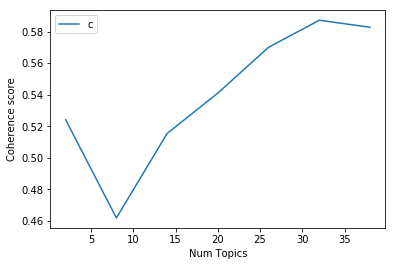

In [57]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=cleaned_column, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [58]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5241
Num Topics = 8  has Coherence Value of 0.4618
Num Topics = 14  has Coherence Value of 0.5154
Num Topics = 20  has Coherence Value of 0.541
Num Topics = 26  has Coherence Value of 0.5701
Num Topics = 32  has Coherence Value of 0.5872
Num Topics = 38  has Coherence Value of 0.5828


Si le score de cohérence semble continuer à augmenter, il peut être préférable de choisir le modèle qui a donné le CV le plus élevé avant d'aplatir. C'est exactement le cas ici.

Donc, pour les prochaines étapes, je choisirai le modèle avec 20 sujets.

# *Remarque* : il existe de nombreuses autres approches pour évaluer les modèles de sujets tels que Perplexity, mais son indicateur médiocre de la qualité des sujets. TOPIC COHERENCE MEASURE est également un bon moyen d'évaluer les modèles de sujet. La mesure de la cohérence des sujets est un bon moyen de comparer les modèles de sujets différents en fonction de leur interprétabilité humaine. 

In [59]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(9,
  '0.018*"android" + 0.016*"music" + 0.015*"cyrus" + 0.014*"miley" + '
  '0.014*"play" + 0.013*"googl" + 0.012*"ceo" + 0.012*"mad" + 0.012*"app" + '
  '0.012*"data"'),
 (11,
  '0.033*"compani" + 0.032*"ebola" + 0.022*"outbreak" + 0.019*"virus" + '
  '0.018*"use" + 0.016*"propos" + 0.015*"grow" + 0.013*"public" + '
  '0.011*"govern" + 0.011*"investig"'),
 (6,
  '0.039*"amazon" + 0.028*"launch" + 0.022*"smartphon" + 0.022*"death" + '
  '0.017*"america" + 0.016*"life" + 0.015*"reach" + 0.014*"walk" + '
  '0.014*"season" + 0.013*"new"'),
 (3,
  '0.020*"increas" + 0.018*"deal" + 0.017*"gas" + 0.015*"beyonc" + '
  '0.015*"russia" + 0.014*"jay" + 0.012*"alleg" + 0.012*"latest" + '
  '0.012*"attack" + 0.011*"host"'),
 (28,
  '0.056*"samsung" + 0.046*"galaxi" + 0.025*"facebook" + 0.019*"wall" + '
  '0.019*"featur" + 0.015*"street" + 0.014*"app" + 0.012*"android" + '
  '0.012*"scientist" + 0.011*"note"'),
 (21,
  '0.025*"award" + 0.019*"japan" + 0.018*"second" + 0.017*"close" + '
  '0.017*"

In [ ]:
Ce sont les thèmes du modèle LDA choisi.

# 8)  Trouver le sujet dominant dans chaque phrase

L'une des applications pratiques de la modélisation de sujets consiste à déterminer le sujet d'un document donné.

Pour trouver cela, nous trouvons le numéro de sujet qui contient le pourcentage de contribution le plus élevé dans ce document.

La fonction ci-dessous agrège bien ces informations dans une table présentable.format_topics_sentences()

In [60]:
def format_topics_sentences(ldamodel=model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=cleaned_column)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.1969,"video, season, game, new, final, announc, thro...","[spoiler, free, busi, lesson, game, throne]"
1,1,9.0,0.4395,"end, home, phone, expect, smartphon, quarter, ...","[robin, william, enter, treatment, fine, tune,..."
2,2,5.0,0.2051,"rise, world, die, googl, open, go, babi, glass...","[fact, american, creep, googl, glass]"
3,3,12.0,0.3285,"look, bank, record, help, warn, rate, men, nee...","[ail, space, telescop, get, nd, chanc]"
4,4,14.0,0.5172,"price, sale, news, releas, data, reveal, new, ...","[jack, white, reveal, detail, new, album, laza..."
5,5,5.0,0.1489,"rise, world, die, googl, open, go, babi, glass...","[king, crush, debut]"
6,6,5.0,0.3059,"rise, world, die, googl, open, go, babi, glass...","[woman, help, appl, save, planet]"
7,7,2.0,0.4628,"stock, buy, deal, billion, like, sell, compani...","[merger, domin, wall, street, trade, durabl, g..."
8,8,11.0,0.1926,"day, chang, futur, best, drug, unveil, post, h...","[rumor, appl, unveil, home, autom, week]"
9,9,15.0,0.3639,"year, share, hit, twitter, car, mobil, state, ...","[conscious, uncoupl, pretenti, defens, word, w..."


# 9) Trouver le document le plus représentatif pour chaque sujet

Parfois, seuls les mots-clés du sujet peuvent ne pas suffire à donner un sens au sujet. Donc, pour aider à comprendre le sujet, vous pouvez trouver les documents auxquels un sujet donné a le plus contribué et déduire le sujet en lisant ce document. 

In [61]:
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted = pd.concat([sent_topics_sorted, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorted.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5661,"music, talk, photo, man, tv, profit, uk, week,...","[marc, webb, talk, amaz, spider, man, plot]"
1,1.0,0.5604,"say, million, recal, gm, ceo, internet, award,...","[batman, suit, pic, forget, kevin, smith, say,..."
2,2.0,0.6288,"stock, buy, deal, billion, like, sell, compani...","[india, sun, pharma, buy, troubl, drugmak, ran..."
3,3.0,0.5967,"star, time, war, join, cast, return, window, c...","[christina, chong, join, cast, star, war, epis..."
4,4.0,0.5565,"video, season, game, new, final, announc, thro...","[codi, simpson, danc, star, cha, cha, cha, vid..."


Le tableau ci-dessus contient le numéro du sujet, les mots-clés et le document le plus représentatif. La Topic_Perc_Contribution colonne n'est rien d'autre que le pourcentage de contribution du sujet dans le document donné.

# 10)  Distribution de sujets entre documents

Enfin, nous souhaitons comprendre le volume et la distribution des sujets afin de juger de l’ampleur des discussions. Le tableau ci-dessous expose ces informations.

In [62]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(20)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,4.0,"video, season, game, new, final, announc, thro...",354.0,0.0354
1,9.0,"end, home, phone, expect, smartphon, quarter, ...",539.0,0.0539
2,5.0,"rise, world, die, googl, open, go, babi, glass...",681.0,0.0681
3,12.0,"look, bank, record, help, warn, rate, men, nee...",434.0,0.0434
4,14.0,"price, sale, news, releas, data, reveal, new, ...",680.0,0.0680
5,5.0,"rise, world, die, googl, open, go, babi, glass...",515.0,0.0515
6,5.0,"rise, world, die, googl, open, go, babi, glass...",405.0,0.0405
7,2.0,"stock, buy, deal, billion, like, sell, compani...",878.0,0.0878
8,11.0,"day, chang, futur, best, drug, unveil, post, h...",423.0,0.0423
9,15.0,"year, share, hit, twitter, car, mobil, state, ...",383.0,0.0383


# 11) Conclusion

### En gros, nous avons construit un modèle de sujet de base en utilisant le LDA de Gensim et visualisé les sujets en utilisant pyLDAvis. Ensuite, nous avons vu comment trouver le nombre optimal de sujets en utilisant les scores de cohérence et comment comprendre logiquement comment choisir le modèle optimal.

### Enfin, nous avons vu comment agréger et présenter les résultats pour générer des informations qui pourraient être plus exploitables.